In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np 
import pandas as pd 
import re
import matplotlib.pyplot as plt
import seaborn as sns
import collections
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.metrics import accuracy_score, classification_report

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current sessionimport warnings
warnings.filterwarnings('ignore')
import numpy as np 
import pandas as pd 
import re
import matplotlib.pyplot as plt
import seaborn as sns
import collections
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.metrics import accuracy_score, classification_report

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset_v2.json
/kaggle/input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset.json
/kaggle/input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset_v2.json
/kaggle/input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset.json


In [2]:
df_v1 = pd.read_json('../input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset.json', lines = True)
df_v2 = pd.read_json('../input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset_v2.json', lines = True)

In [3]:
df_v1.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [4]:
df_v2.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


In [5]:
df = pd.concat([df_v1, df_v2], axis=0)

In [6]:
df.shape


(55328, 3)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 55328 entries, 0 to 28618
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   article_link  55328 non-null  object
 1   headline      55328 non-null  object
 2   is_sarcastic  55328 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [8]:
df.isnull().sum()

article_link    0
headline        0
is_sarcastic    0
dtype: int64

In [9]:
df.drop('article_link', axis=1, inplace=True)

In [10]:
df.columns = ['text', 'labels']


In [11]:
df.duplicated().sum()


26825

In [12]:
df.drop_duplicates(keep='first', inplace=True)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28503 entries, 0 to 28589
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    28503 non-null  object
 1   labels  28503 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 668.0+ KB


In [14]:
df['labels'].value_counts()

labels
0    14951
1    13552
Name: count, dtype: int64

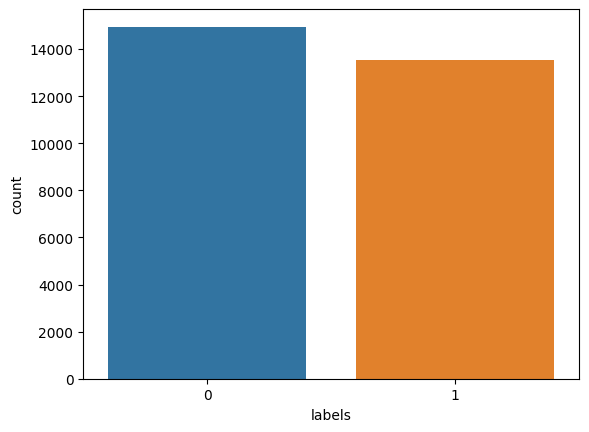

In [15]:
sns.countplot(x= df['labels'])
plt.show()

<Axes: xlabel='labels', ylabel='Count'>

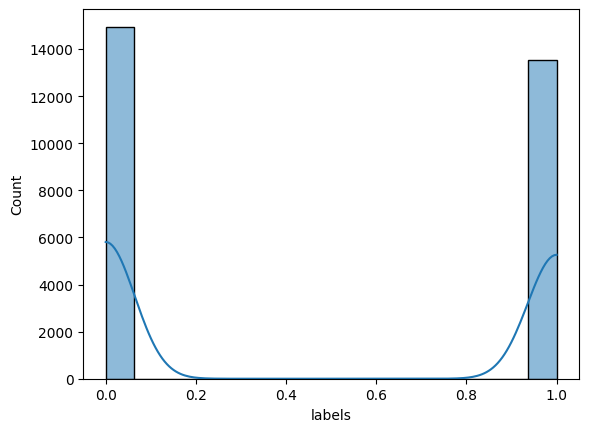

In [16]:
sns.histplot(df['labels'], kde=True)


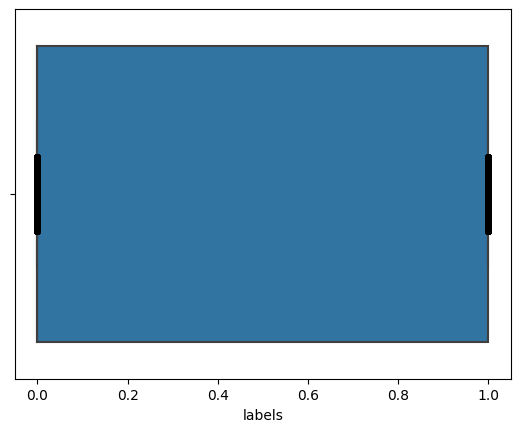

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x='labels', data=df)

sns.stripplot(x='labels', data=df, color='black', jitter=True)  # Add strip or swarm plot on top

plt.show()


In [18]:
regex = re.compile('[^a-z\s]')

df['text'] = df['text'].str.lower()
df['text'] = df['text'].apply(lambda x: regex.sub('', x))
df['text'] = df['text'].str.replace('rt|http', '', regex = True)
df['text'] = df['text'].apply(lambda x: ' '.join([w for w in x.split() if len(w) > 2]))

In [19]:
df['text'] = df['text'].apply(word_tokenize)

stop_words = set(stopwords.words('english'))
df['text'] = df['text'].apply(lambda x: [word for word in x if word not in stop_words])

In [20]:
stemmer = SnowballStemmer('english')
df['text'] = df['text'].apply(lambda x: [stemmer.stem(w) for w in x])
# Joining the words back into a single text
df['text'] = df['text'].apply(lambda x: ' '.join(x))

In [21]:
all_words = ' '.join(word for word in df['text'])

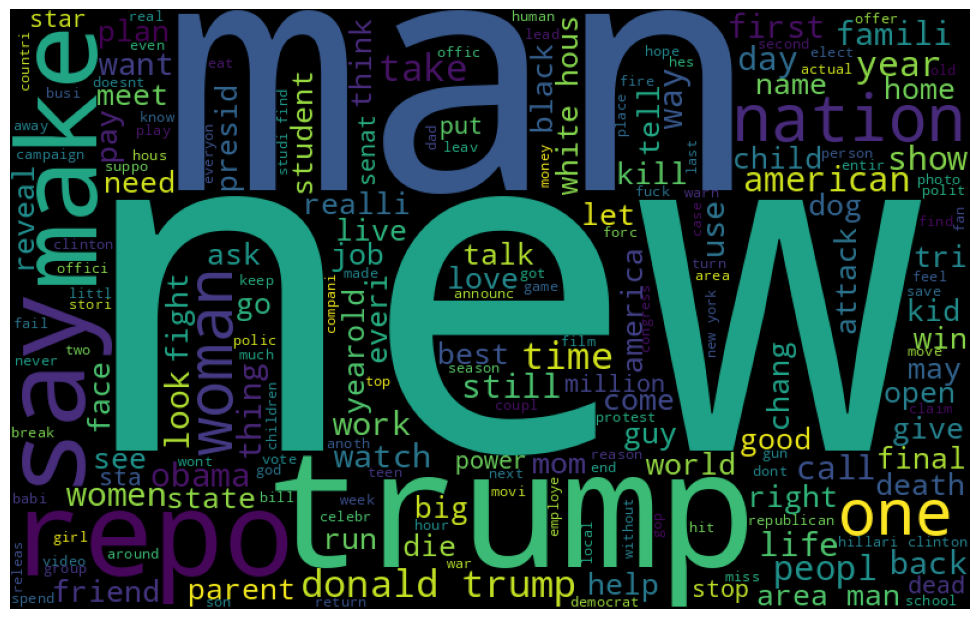

In [22]:
wordcloud = WordCloud(width = 800, height = 500, background_color = 'black', 
                min_font_size = 10).generate(all_words)

plt.figure(figsize = (10, 6), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis('off') 
plt.tight_layout(pad = 0) 
plt.show()

In [23]:
X = np.array(df['text'])
y = np.array(df['labels'])

In [24]:
cv = CountVectorizer()
X = cv.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state= 42)

In [25]:
bnb = BernoulliNB()
bnb.fit(X_train, y_train)

BernoulliNB()

In [26]:
y_pred = bnb.predict(X_test)

In [27]:
print("Classification Report: \n", classification_report(y_test, y_pred))


Classification Report: 
               precision    recall  f1-score   support

           0       0.79      0.83      0.81      2991
           1       0.80      0.76      0.78      2710

    accuracy                           0.80      5701
   macro avg       0.80      0.80      0.80      5701
weighted avg       0.80      0.80      0.80      5701

